# Plot Images

## Modules

In [1]:
#Modules
import numpy as np

import torch
from torchvision import transforms, utils as vutils

import os

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.manifold import MDS

from load_data import TARGET_MAP, AFHQ_TARGET_PROMPTS, FFHQ_TARGET_PROMPT, COCO_TARGET_PROMPT

In [2]:
#Hyper-parameters
figure_path = '../figures/'
base_path = '../generated_figures/figures/'

#IVP
ivp_type = "cat"
N_images = 5
ivp_methods = {
    'ProbGEORCE': f"{base_path}{ivp_type}/ivp/ProbGEORCE_prior_noise_20d0",
    'Baseline1': f"{base_path}{ivp_type}/ivp/ProbGEORCE_prior_noise_20d0",
    'Baseline2': f"{base_path}{ivp_type}/ivp/ProbGEORCE_prior_noise_20d0",
}

#BVP
bvp_type = "cat"
N_images = 5
bvp_methods = {
    'ProbGEORCE (Noise)': f"{base_path}{bvp_type}/bvp/ProbGEORCE_prior_noise_20d0",
    #'ProbGEORCE (Data)': f"{base_path}{bvp_type}/bvp/ProbGEORCE_score_data_10d0",
    'Linear': f"{base_path}{bvp_type}/bvp/Linear",
    'Spherical': f"{base_path}{bvp_type}/bvp/Spherical",
    'NoiseDiffusion': f"{base_path}{bvp_type}/bvp/NoiseDiffusion",
}

#Mean
mean_type = "afhq"
N_images = 5
mean_methods = {
    'ProbGEORCE (Noise)': f"{base_path}{mean_type}/mean/ProbGEORCE_prior_noise_20d0",
    'ProbGEORCE (Data)': f"{base_path}{mean_type}/mean/ProbGEORCE_score_data_10d0",
    'Linear': f"{base_path}{mean_type}/mean/Linear",
    'Spherical': f"{base_path}{mean_type}/mean/Spherical",
}

In [3]:
figure_path_ivp = f"{figure_path}{ivp_type}/ivp/"
figure_path_bvp = f"{figure_path}{bvp_type}/bvp/"
figure_path_mean = f"{figure_path}{mean_type}/mean/"

In [4]:
if not os.path.exists(figure_path_ivp):
    os.makedirs(figure_path_ivp)

if not os.path.exists(figure_path_bvp):
    os.makedirs(figure_path_bvp)

if not os.path.exists(figure_path_mean):
    os.makedirs(figure_path_mean)

## Helper functions

### Interpolationn plots

In [5]:
def plot_image_row(
    folder,
    header=None,
    left_label=None,
    right_label=None,
    center_text=None,       # <-- new argument
    padding=0,
    normalize=False,
    cmap=None,
    header_fontsize=14,
    label_fontsize=12,
    N_images=None,
    save_path:str="image_row",
    ):
    """
    Parameters
    ----------
    folder : str
        Path to folder with {i}.png images
    header : str or None
        Optional header text (above the row)
    left_label : str or None
        Text under the first image
    right_label : str or None
        Text under the last image
    center_text : str or None
        Text under the center image
    N_images : int or None
        Number of images to show (equally spaced). If more than available, all images are used.
    """

    to_tensor = transforms.ToTensor()
    imgs = []

    # -------- load images sorted numerically --------
    files = []
    for fname in os.listdir(folder):
        if fname.endswith(".png"):
            try:
                idx = int(os.path.splitext(fname)[0])
            except ValueError:
                raise ValueError(f"Filename {fname} is not of the form {{i}}.png")
            files.append((idx, fname))

    files = sorted(files, key=lambda x: x[0])

    # -------- select N_images if requested --------
    if N_images is not None and len(files) > 0:
        actual_N = min(N_images, len(files))  # cap to available images
        if actual_N == 1:
            files = [files[0]]
        else:
            idxs = np.linspace(0, len(files) - 1, actual_N, dtype=int)
            files = [files[k] for k in idxs]

    for _, fname in files:
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        imgs.append(to_tensor(img))

    if len(imgs) == 0:
        raise ValueError(f"No PNG images found in {folder}")

    imgs = torch.stack(imgs)  # [N, C, H, W]
    ncol = imgs.shape[0]

    # -------- make grid --------
    grid = vutils.make_grid(
        imgs,
        nrow=ncol,
        padding=padding,
        normalize=normalize
    )

    # -------- plot --------
    fig = plt.figure(figsize=(2 * ncol, 2))
    ax = fig.add_subplot(111)
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- header --------
    if header is not None:
        ax.text(
            0.5,
            1.05,
            header,
            ha="center",
            va="bottom",
            transform=ax.transAxes,
            fontsize=header_fontsize,
            clip_on=False
        )

    # -------- labels under first / last / center --------
    y_text = -0.08
    col_width = 1.0 / ncol

    if left_label is not None:
        ax.text(
            col_width / 2,
            y_text,
            left_label,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=label_fontsize,
            clip_on=False
        )

    if right_label is not None:
        ax.text(
            1.0 - col_width / 2,
            y_text,
            right_label,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=label_fontsize,
            clip_on=False
        )

    if center_text is not None:
        ax.text(
            0.5,
            y_text,
            center_text,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=label_fontsize,
            clip_on=False
        )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()


In [6]:
def plot_image_grid(
    folder_dict,
    padding=0,
    normalize=False,
    cmap=None,
    label_fontsize=12,
    N_images=None,  # <-- new argument
    save_path:str="image_grid",
    ):
    """
    Parameters
    ----------
    folder_dict : dict
        {NAME: FOLDER_PATH}, each folder contains images {i}.png
    padding : int
        Padding between images in the grid
    normalize : bool
        Whether to normalize images when plotting
    cmap : str or None
        Colormap
    label_fontsize : int
        Font size for row labels
    N_images : int or None
        Number of images per row to show (equally spaced). If more than available, all images are used.
    """

    to_tensor = transforms.ToTensor()
    row_tensors = []
    names = []

    # -------- load images per folder --------
    max_cols = 0
    for name, folder in folder_dict.items():
        imgs = []

        # load images sorted numerically
        files = []
        for fname in os.listdir(folder):
            if fname.endswith(".png"):
                idx = int(os.path.splitext(fname)[0])
                files.append((idx, fname))

        files = sorted(files, key=lambda x: x[0])

        # -------- select N_images if requested --------
        if N_images is not None and len(files) > 0:
            actual_N = min(N_images, len(files))  # cap to available images
            if actual_N == 1:
                files = [files[0]]
            else:
                idxs = np.linspace(0, len(files) - 1, actual_N, dtype=int)
                files = [files[k] for k in idxs]

        for _, fname in files:
            img = Image.open(os.path.join(folder, fname)).convert("RGB")
            imgs.append(to_tensor(img))

        if len(imgs) == 0:
            raise ValueError(f"No PNG images found in folder {folder}")

        row_tensors.append(torch.stack(imgs))  # shape [N, C, H, W]
        names.append(name)
        max_cols = max(max_cols, len(imgs))

    # -------- pad rows to same number of columns --------
    padded_rows = []
    for row in row_tensors:
        if row.shape[0] < max_cols:
            # pad with zeros instead of repeating last image
            C, H, W = row.shape[1:]
            n_pad = max_cols - row.shape[0]
            pad_imgs = torch.zeros(n_pad, C, H, W)
            row = torch.cat([row, pad_imgs], dim=0)
        padded_rows.append(row)

    # -------- stack all rows --------
    grid_tensor = torch.cat(padded_rows, dim=0)  # [total_images, C, H, W]

    # -------- make grid --------
    grid = vutils.make_grid(
        grid_tensor,
        nrow=max_cols,
        padding=padding,
        normalize=normalize
    )

    nrows = len(folder_dict)
    fig_height = 2 * nrows
    fig = plt.figure(figsize=(2 * max_cols, fig_height))
    ax = fig.add_subplot(111)
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- row labels (to the left) --------
    row_height = 1.0 / nrows
    for i, name in enumerate(names):
        # place label at the middle of the row
        ax.text(
            -0.01,                        # slightly left of the grid
            1.0 - (i + 0.5) * row_height, # y position
            name,
            ha="right",
            va="center",
            transform=ax.transAxes,
            fontsize=label_fontsize,
            clip_on=False
        )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()


### Mean plots

In [7]:
def plot_mean_grid(
    folder,
    padding=0,
    normalize=False,
    cmap=None,
    header_fontsize=14,
    title_name=None,
    save_path: str = "mean_grid",
    N_images: int = None  # <-- new argument
    ):
    to_tensor = transforms.ToTensor()
    groups = {}

    # -------- load & group images --------
    for fname in os.listdir(folder):
        if not fname.endswith(".png"):
            continue

        try:
            i, j = map(int, fname.replace(".png", "").split("_"))
        except ValueError:
            raise ValueError(f"Filename {fname} is not of the form 'i_j.png'")
        
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        img = to_tensor(img)

        groups.setdefault(i, []).append((j, img))

    # -------- build full grid tensor --------
    all_imgs = []
    ncol = None
    nrow = len(groups)

    for i in sorted(groups.keys()):
        items = sorted(groups[i], key=lambda x: x[0])
        
        # -------- select N_images if requested --------
        if N_images is not None and len(items) > 0:
            actual_N = min(N_images, len(items))
            if actual_N == 1:
                items = [items[0]]
            else:
                idxs = np.linspace(0, len(items) - 1, actual_N, dtype=int)
                items = [items[k] for k in idxs]

        row_imgs = [img for _, img in items]

        if ncol is None:
            ncol = len(row_imgs)

        all_imgs.extend(row_imgs)

    if len(all_imgs) == 0:
        raise ValueError(f"No PNG images found in {folder}")

    grid_tensor = torch.stack(all_imgs)

    grid = vutils.make_grid(
        grid_tensor,
        nrow=ncol,
        padding=padding,
        normalize=normalize
    )

    # -------- plot --------
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- headers (below last row) --------
    col_width = 1.0 / ncol
    y_text = -0.01

    # Mean (first column)
    ax.text(
        col_width / 2,
        y_text,
        "Mean",
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=header_fontsize,
        clip_on=False
    )

    # Data (last column)
    ax.text(
        1.0 - col_width / 2,
        y_text,
        "Data",
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=header_fontsize,
        clip_on=False
    )

    if title_name is not None:
        ax.set_title(f"{title_name}")

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()

In [8]:
def plot_grid_with_mean_left(
    folder,
    mean_caption=None,
    padding=0,
    normalize=False,
    cmap=None,
    header_fontsize=14,
    title_name=None,
    line_color="gray",
    line_width=1.0,
    N_images=None,  # new argument
    save_path:str="mean_left_grid",
    ):
    to_tensor = transforms.ToTensor()
    groups = {}

    # -------- load & group images --------
    for fname in os.listdir(folder):
        if not fname.endswith(".png"):
            continue

        i, j = map(int, fname.replace(".png", "").split("_"))
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        img = to_tensor(img)

        groups.setdefault(i, []).append((j, img))

    # -------- store mean image explicitly --------
    if 0 not in groups or len(groups[0]) == 0:
        raise ValueError("Mean image {0}_{0}.png not found in folder!")
    mean_img = next(img for j, img in groups[0] if j == 0)

    # -------- build row tensors (skip first column j=0) --------
    row_tensors = []
    max_j = 0
    for i in sorted(groups.keys()):
        items = sorted(groups[i], key=lambda x: x[0])
        row_dict = {j: img for j, img in items if j != 0}  # skip j=0
        if len(row_dict) == 0:
            continue

        # -------- select N_images equally spaced if requested --------
        sorted_js = sorted(row_dict.keys())
        if N_images is not None and len(sorted_js) > 0:
            actual_N = min(N_images, len(sorted_js))  # <-- cap to number of available images
            if actual_N == 1:
                selected_js = [sorted_js[0]]
            else:
                idxs = np.linspace(0, len(sorted_js) - 1, actual_N, dtype=int)
                selected_js = [sorted_js[k] for k in idxs]
        else:
            selected_js = sorted_js

        row_imgs = [row_dict[j] for j in selected_js]
        row_tensors.append(torch.stack(row_imgs))
        max_j = max(max_j, len(row_imgs))

    # -------- pad rows to same length --------
    padded_rows = []
    C, H, W = mean_img.shape
    for row in row_tensors:
        if row.shape[0] < max_j:
            n_pad = max_j - row.shape[0]
            pad_imgs = torch.zeros(n_pad, C, H, W)
            row = torch.cat([row, pad_imgs], dim=0)
        padded_rows.append(row)

    # -------- create full grid tensor --------
    full_grid_tensor = torch.cat(padded_rows, dim=0)
    grid = vutils.make_grid(
        full_grid_tensor,
        nrow=max_j,
        padding=padding,
        normalize=normalize
    )

    # -------- plot --------
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- plot mean image on the left, vertically centered --------
    grid_height = grid.shape[1]
    n_rows = len(padded_rows)
    mean_ax_height = 0.1
    mean_ax = fig.add_axes([0.05, 0.5 - mean_ax_height / 2, 0.1, mean_ax_height])
    mean_ax.imshow(mean_img.permute(1, 2, 0))
    mean_ax.axis("off")

    # -------- optional caption under mean --------
    if mean_caption is not None:
        mean_ax.text(
            0.5,
            -0.1,
            mean_caption,
            ha="center",
            va="top",
            transform=mean_ax.transAxes,
            fontsize=header_fontsize,
            clip_on=False
        )

    # -------- draw lines from mean to start of each row --------
    row_height = grid_height / n_rows
    for idx in range(n_rows):
        y = grid_height - (idx + 0.5) * row_height
        ax.plot(
            [-20, 0],
            [y, y],
            color=line_color,
            linewidth=line_width,
            alpha=0.6
        )

    # -------- headers below last row --------
    col_width = 1.0 / max_j
    y_text = -0.01
    ax.text(
        0.5, y_text, "", ha="center", va="top", transform=ax.transAxes
    )
    ax.text(
        1.0 - col_width / 2,
        y_text,
        "Data",
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=header_fontsize,
        clip_on=False
    )

    if title_name:
        ax.set_title(title_name)

    fig.subplots_adjust(left=0.15, right=1, top=1, bottom=0)

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()


In [31]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms
from PIL import Image


def plot_grid_with_mean_top(
    folder,
    mean_caption=None,
    padding=0,
    normalize=False,
    cmap=None,
    header_fontsize=14,
    title_name=None,
    line_color="gray",
    line_width=1.0,
    N_images=None,
    save_path: str = "mean_top_grid",
):
    to_tensor = transforms.ToTensor()
    groups = {}

    # -------- load & group images --------
    for fname in os.listdir(folder):
        if not fname.endswith(".png"):
            continue

        i, j = map(int, fname.replace(".png", "").split("_"))
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        img = to_tensor(img)
        groups.setdefault(i, []).append((j, img))

    # -------- extract mean image (0_0.png) --------
    if 0 not in groups:
        raise ValueError("Mean image 0_0.png not found!")
    mean_img = next(img for j, img in groups[0] if j == 0)

    # -------- collect image matrix [i][j] (skip j=0) --------
    rows = []
    sorted_is = sorted(groups.keys())

    for i in sorted_is:
        items = sorted(groups[i], key=lambda x: x[0])
        row = {j: img for j, img in items if j != 0}
        if len(row) == 0:
            continue

        sorted_js = sorted(row.keys())
        if N_images is not None:
            actual_N = min(N_images, len(sorted_js))
            idxs = np.linspace(0, len(sorted_js) - 1, actual_N, dtype=int)
            selected_js = [sorted_js[k] for k in idxs]
        else:
            selected_js = sorted_js

        rows.append([row[j] for j in selected_js])

    # -------- pad to rectangular tensor --------
    max_i = len(rows)
    max_j = max(len(r) for r in rows)
    C, H, W = mean_img.shape

    tensor = torch.zeros(max_i, max_j, C, H, W)

    for i, r in enumerate(rows):
        for j, img in enumerate(r):
            tensor[i, j] = img

    # -------- TRUE TRANSPOSE (i ↔ j) --------
    tensor = tensor.permute(1, 0, 2, 3, 4)

    # -------- flatten for make_grid --------
    flat = tensor.reshape(-1, C, H, W)

    grid = vutils.make_grid(
        flat,
        nrow=max_i,
        padding=padding,
        normalize=normalize
    )

    # -------- plot grid --------
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- mean image on top --------
    mean_ax_width = 0.18
    mean_ax = fig.add_axes([0.5 - mean_ax_width / 2, 0.84, mean_ax_width, 0.14])
    mean_ax.imshow(mean_img.permute(1, 2, 0))
    mean_ax.axis("off")

    if mean_caption:
        mean_ax.text(
            0.5,
            1.05,
            mean_caption,
            ha="center",
            va="bottom",
            transform=mean_ax.transAxes,
            fontsize=header_fontsize,
            clip_on=False,
        )

    # -------- "Data" label centered under grid --------
    ax.text(
        0.5,
        -0.04,               # slightly below the grid
        "Data",
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=header_fontsize,
        clip_on=False,
    )


    # -------- vertical connectors --------
    grid_width = grid.shape[2]
    n_cols = max_j
    col_width = grid_width / n_cols

    for idx in range(n_cols):
        x = (idx + 0.5) * col_width
        ax.plot(
            [x, x],
            [-25, 0],
            color=line_color,
            linewidth=line_width,
            alpha=0.6,
        )

    if title_name:
        ax.set_title(title_name, pad=40)

    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.82)
    fig.savefig(
        f"{save_path}.pdf",
        format="pdf",
        bbox_inches="tight",
        pad_inches=0.1,
    )
    plt.show()


In [9]:
def plot_2d_interpolation_map_mean(
    folder,
    image_size=0.15, 
    random_state=42,
    save_path:str="2d_mean_map",
):
    """
    Plot a 2D embedding of mean and last data points of each i.

    Parameters
    ----------
    folder : str
        Folder containing images {i}_{j}.png
    image_size : float
        Size of displayed mean/data images
    random_state : int
        Random state for MDS
    """
    to_tensor = transforms.ToTensor()
    images = {}
    keys_for_embedding = []
    vectors_for_embedding = []

    # -------- load images and group by i --------
    groups = {}
    for fname in os.listdir(folder):
        if not fname.endswith(".png"):
            continue
        i, j = map(int, fname.replace(".png", "").split("_"))
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        groups.setdefault(i, []).append((j, img))

    # -------- determine images to plot --------
    mean_img = groups[0][0][1]  # 0_0.png
    images["0_0"] = mean_img
    keys_for_embedding.append("0_0")
    vectors_for_embedding.append(np.array(mean_img).flatten())

    data_keys = []
    for i in sorted(groups.keys()):
        if i == 0:
            continue
        # pick the last j for this i
        last_j, last_img = sorted(groups[i], key=lambda x: x[0])[-1]
        key = f"{i}_{last_j}"
        images[key] = last_img
        data_keys.append(key)
        keys_for_embedding.append(key)
        vectors_for_embedding.append(np.array(last_img).flatten())

    vectors_for_embedding = np.stack(vectors_for_embedding)

    # -------- compute 2D embedding with MDS --------
    mds = MDS(n_components=2, random_state=random_state, dissimilarity="euclidean")
    coords = mds.fit_transform(vectors_for_embedding)

    coords_dict = {k: tuple(c) for k, c in zip(keys_for_embedding, coords)}

    # -------- plot points and lines --------
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # scatter all points (mean + data)
    xs, ys = coords[:, 0], coords[:, 1]
    ax.scatter(xs, ys, color="lightgray", s=20, zorder=1)

    mean_coord = coords_dict["0_0"]
    # draw lines from mean to each data point
    for dk in data_keys:
        data_coord = coords_dict[dk]
        ax.plot(
            [mean_coord[0], data_coord[0]],
            [mean_coord[1], data_coord[1]],
            color="gray",
            alpha=0.5,
            zorder=0
        )

    # -------- plot images --------
    def plot_image(ax, img, coord, zoom):
        imbox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imbox, coord, frameon=False)
        ax.add_artist(ab)

    plot_image(ax, mean_img, mean_coord, zoom=image_size)
    for dk in data_keys:
        plot_image(ax, images[dk], coords_dict[dk], zoom=image_size)

    ax.set_aspect("equal")
    ax.axis("off")

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()


In [10]:
def plot_mean_row(
    folder_dict,
    padding=0,
    normalize=False,
    cmap=None,
    label_fontsize=12,
    save_path:str="mean_row",
    ):
    """
    Parameters
    ----------
    folder_dict : dict
        {NAME: FOLDER_PATH}
    """

    to_tensor = transforms.ToTensor()
    imgs = []
    names = []

    # -------- load mean images --------
    for name, folder in folder_dict.items():
        mean_path = os.path.join(folder, "0_0.png")

        if not os.path.exists(mean_path):
            raise FileNotFoundError(f"Missing mean image: {mean_path}")

        img = Image.open(mean_path).convert("RGB")
        img = to_tensor(img)

        imgs.append(img)
        names.append(name)

    imgs = torch.stack(imgs)  # [N, C, H, W]

    # -------- make grid --------
    grid = vutils.make_grid(
        imgs,
        nrow=len(imgs),
        padding=padding,
        normalize=normalize
    )

    # -------- plot --------
    fig = plt.figure(figsize=(2 * len(imgs), 2))
    ax = fig.add_subplot(111)
    ax.imshow(grid.permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

    # -------- labels below images --------
    ncol = len(imgs)
    col_width = 1.0 / ncol
    y_text = -0.08

    for idx, name in enumerate(names):
        ax.text(
            (idx + 0.5) * col_width,
            y_text,
            name,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=label_fontsize,
            clip_on=False
        )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.savefig(f"{save_path}.pdf", format='pdf', pad_inches=0.1, bbox_inches='tight')
    
    plt.show()


## Plotting IVP Solution

In [11]:
if "afhq" in ivp_type:
    target_prompt = AFHQ_TARGET_PROMPTS[ivp_type.split("-")[1]]
elif "coco" in ivp_type:
    target_prompt = COCO_TARGET_PROMPT
elif "FFHQ" in ivp_type:
    target_prompt = FFHQ_TARGET_PROMPT
else:
    target_prompt = TARGET_MAP[ivp_type]


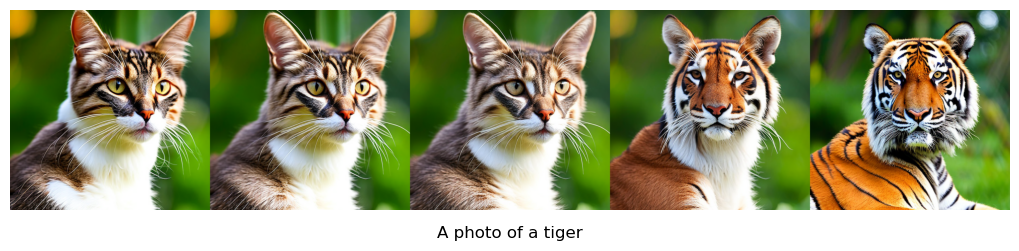

In [12]:
plot_image_row(
    ivp_methods['ProbGEORCE'],
    header=None,
    center_text=target_prompt,
    left_label=None,
    right_label=None,
    N_images=N_images,
    save_path=f"{figure_path_ivp}image_row",
)


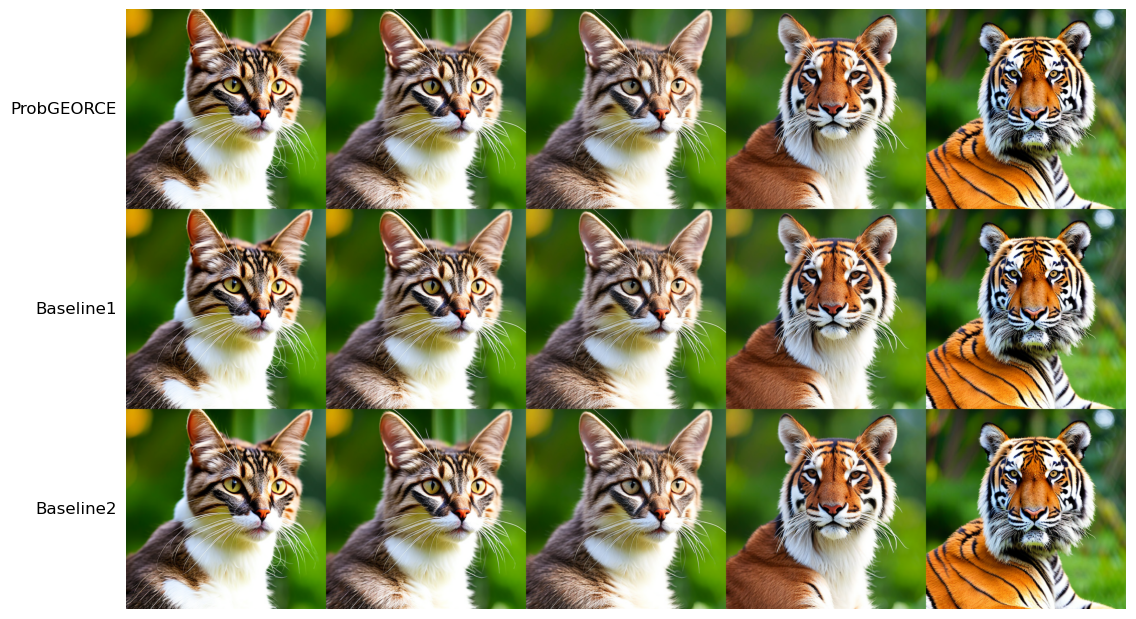

In [13]:
plot_image_grid(
    ivp_methods, 
    normalize=True, 
    N_images=N_images,
    save_path=f"{figure_path_ivp}image_grid",
)

## Plotting BVP Solutions

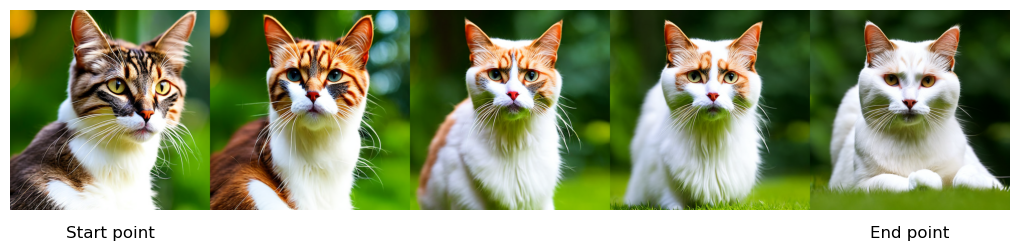

In [14]:
plot_image_row(
    bvp_methods['ProbGEORCE (Noise)'],
    header=None,
    center_text=None,
    left_label="Start point",
    right_label="End point",
    N_images=N_images,
    save_path=f"{figure_path_bvp}image_row",
)


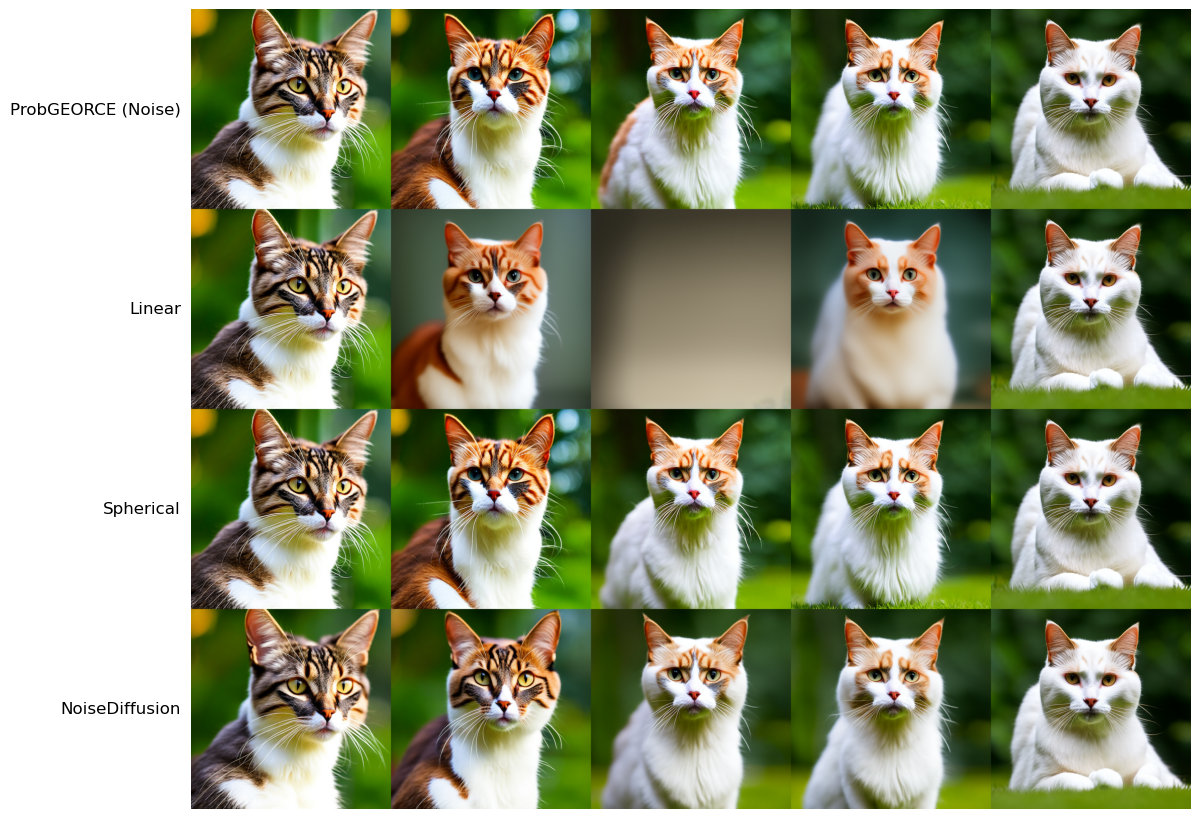

In [15]:
plot_image_grid(
    bvp_methods, 
    normalize=True, 
    N_images=N_images,
    save_path=f"{figure_path_bvp}image_grid",
)

## Plotting mean images

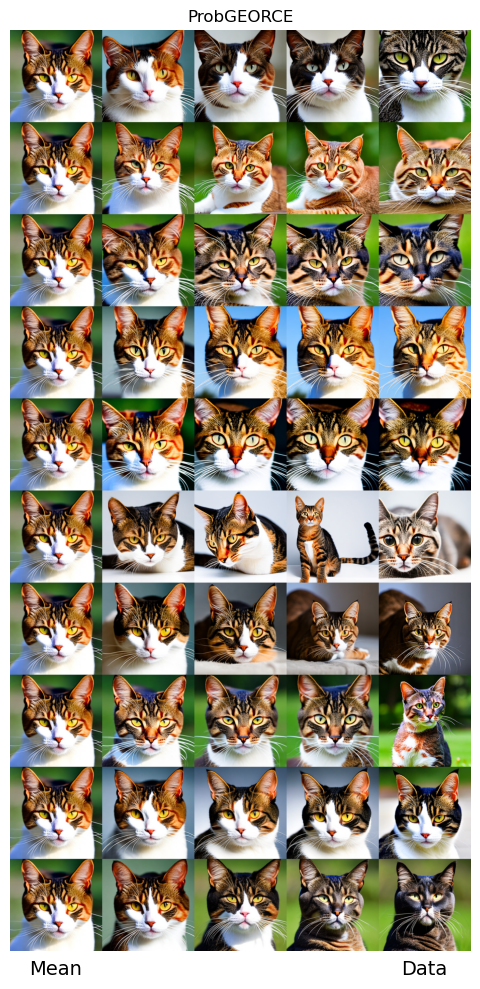

In [16]:
plot_mean_grid(
    folder=mean_methods['ProbGEORCE (Noise)'],
    padding=0,
    title_name="ProbGEORCE",
    N_images = N_images,
    save_path=f"{figure_path_mean}mean_grid",
)


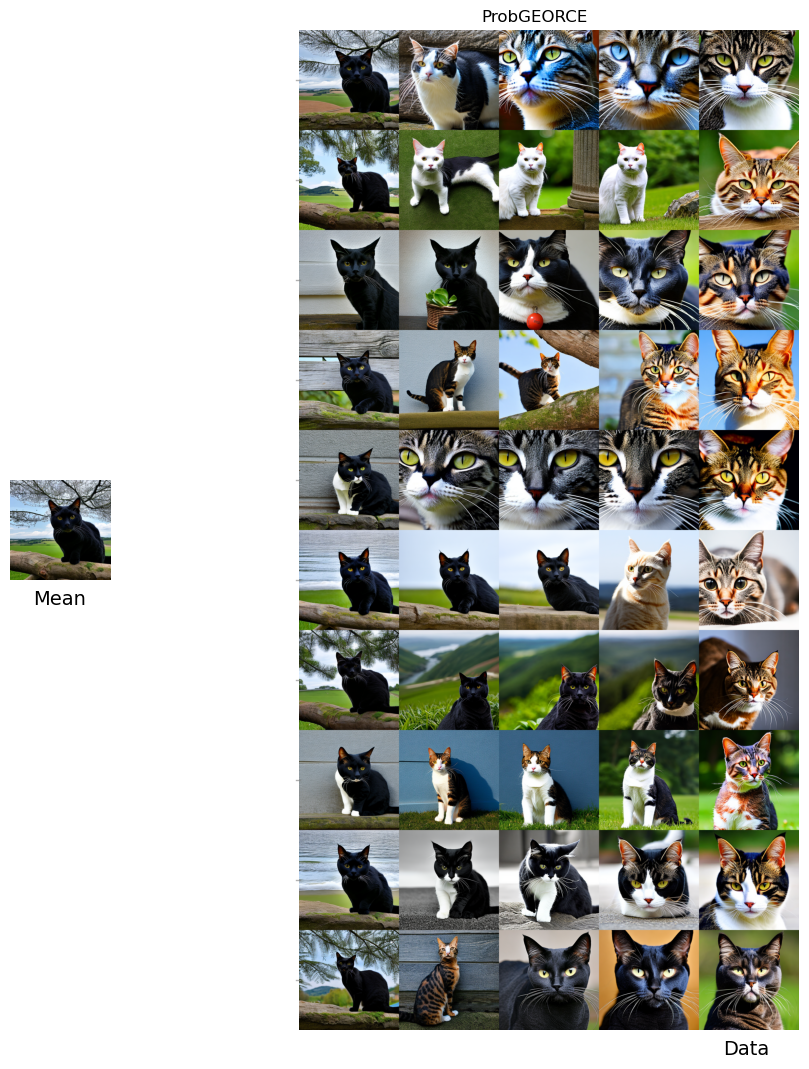

In [34]:
plot_grid_with_mean_left(
    folder=mean_methods['Spherical'],
    padding=0,
    mean_caption="Mean",
    title_name="ProbGEORCE",
    N_images=N_images,
    save_path=f"{figure_path_mean}mean_grid_left",
)


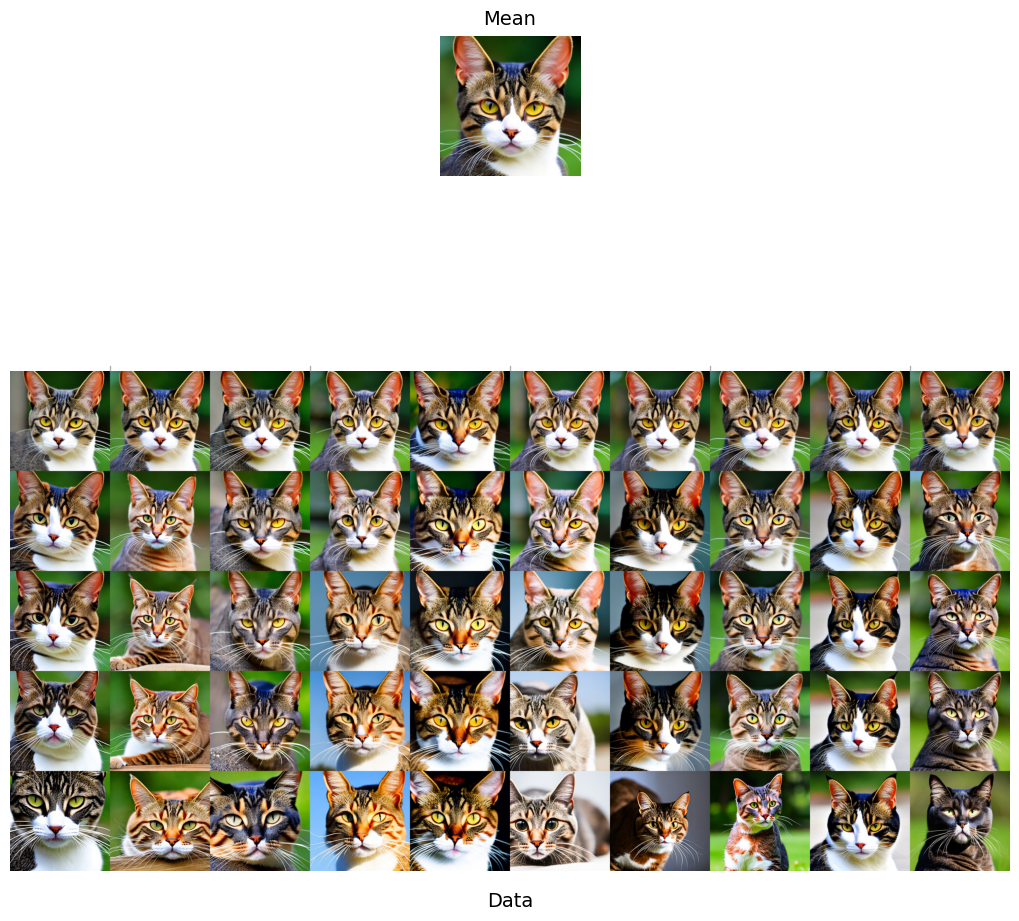

In [32]:
plot_grid_with_mean_top(
    folder=mean_methods['ProbGEORCE (Data)'],
    padding=0,
    mean_caption="Mean",
    title_name=None,
    N_images=N_images,
    save_path=f"{figure_path_mean}mean_grid_top",
)


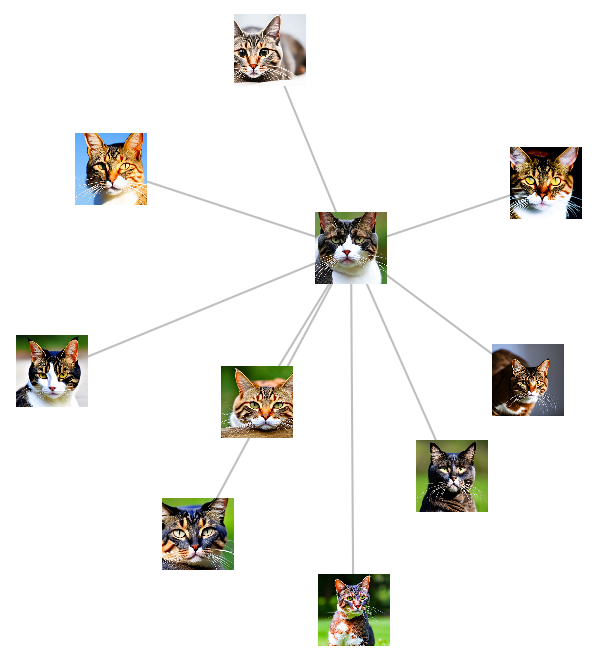

In [21]:
plot_2d_interpolation_map_mean(
    mean_methods['ProbGEORCE (Data)'],
    image_size=0.10,
    save_path=f"{figure_path_mean}2d_mean",
)

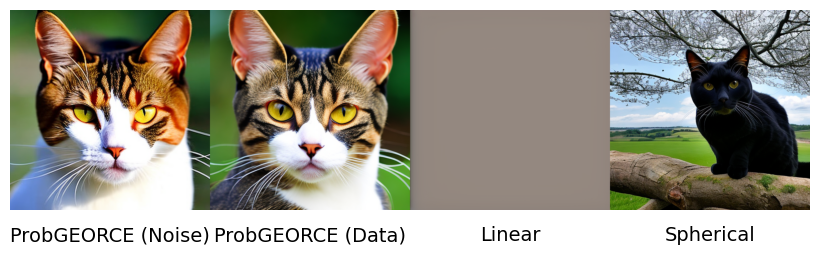

In [19]:
plot_mean_row(
    mean_methods,
    padding=0,
    normalize=True,
    label_fontsize=14,
    save_path=f"{figure_path_mean}mean_row",
)